In [ ]:
# default_exp plot_light

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.dates as md
import matplotlib as mpl

from datetime import time

In [ ]:
def plot_light(d_list, l_list,
               toplot = "mean/sem",
               y_lim = 1000, y_label = "Lux",
               palette=sns.color_palette('deep')):
    
    assert ( len(d_list) == len(l_list) )
    dm = []
    dlo = []
    dhi = []
    tinc = 200
    
    if toplot == "mean/sem":
        for d in d_list:
            dm.append(pd.Series(d.mean()).sort_index())
            tmp = pd.Series(d.sem()).sort_index()
            dlo.append( dm[-1] - tmp )
            dhi.append( dm[-1] + tmp )
    elif toplot == "counts":
        tinc = 5000
        toplot = ''
        y_label = "Number of samples "
        y_lim = np.max( [d1m.max(), d2m.max()] ) * 1.05
        for d in d_list:
            dm.append( d.count().sort_index() )
            dlo.append( dm[-1] )
            dhi.append( dm[-1] )
    elif toplot=="quantiles":
        for d in d_list:
            dm.append( d.median().sort_index() )
            dlo.append( d.quantile(0.25).sort_index() )
            dhi.append( d.quantile(0.75).sort_index() )
    else:
        print("What do you want to plot? Valid options include:")
        print("mean/sem , counts , quantiles")
        return
    
    plt.figure(figsize=(8,6))
    ax=plt.gca()
    
    pidx = 0
    for mid, lo, hi, lab in zip(dm,dlo,dhi,l_list):
        cval = mpl.colors.to_hex( palette[pidx] )
        pidx = pidx + 1
        timval = [ pd.Timestamp(av.isoformat()) for av in mid.index.tolist() ]
               
        vals = pd.DataFrame( mid )
        vals['time']=vals.index.to_series()
        vals['mins']=vals.time.apply(lambda x: x.second/60.0 + x.minute + x.hour*60.0)
        vals['lux-mins']=vals['White Light']*vals['mins']
        v = vals['lux-mins'].mean()/vals['White Light'].mean()
        hrs = int(v/1440*24)
        mins = int( (v - hrs*60) )
        tmid = time( hrs, mins)
        print ('{} - cumulative {}*sec: {:e}, center of mass of light exposure: {}'.format(lab,y_label.strip(),mid.sum()*20,tmid))
        lab = lab+'\n{:4.3e} lx*s, COLE {}'.format(mid.sum()*20,tmid)
        
        ax.plot(timval, mid.values, color=cval, label=lab)
        ax.fill_between(timval, hi.values, lo.values, color=cval, alpha=0.33)
        
    ax.legend()

    # format the ticks
    tFmt = md.DateFormatter('%H:%M')
    ax.xaxis.set_major_locator(md.HourLocator(byhour=range(0,24,4)))
    ax.xaxis.set_major_formatter(tFmt)
    ax.set_ylim(0,y_lim)
    ax.yaxis.set_ticks(np.arange(tinc,y_lim,tinc))

    ax.grid(True)
    plt.ylabel(y_label + toplot)
    plt.xlabel('Time of day')


## Note:

The original notebook takes in processed "allData", prints all the quarters available in the data and then assuming each of these has a "White Light" column, creates lists with the values (the columns) and corresponding labels to throw at the function to plot. 


In [ ]:
file_prefix = "example_output/"

In [ ]:
all_data = pd.read_parquet(file_prefix+'raw.parquet')
all_data.head()

,Off-Wrist Status,Activity,Marker,White Light,Red Light,Green Light,Blue Light,Sleep/Wake,Interval Status,UID,Group
DateTime,,,,,,,,,,,
2018-05-07 11:28:00,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,ACTIVE,v1data\v1,v1
2018-05-07 11:28:30,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,ACTIVE,v1data\v1,v1
2018-05-07 11:29:00,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,ACTIVE,v1data\v1,v1
2018-05-07 11:29:30,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,ACTIVE,v1data\v1,v1
2018-05-07 11:30:00,0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,ACTIVE,v1data\v1,v1


In [ ]:
def quarter_hourly(dtime):
    tm = pd.to_datetime('{}:{:02d}'.format(dtime.hour,(dtime.minute//15)*15))
    return tm.time()

In [ ]:
all_data.columns

Index(['Off-Wrist Status', 'Activity', 'Marker', 'White Light', 'Red Light',
       'Green Light', 'Blue Light', 'Sleep/Wake', 'Interval Status', 'UID',
       'Group'],
      dtype='object')

In [ ]:
these_rows = np.logical_and( np.logical_not(all_data['Off-Wrist Status']), np.logical_and( all_data['Interval Status'].isin(['ACTIVE','REST']), all_data['White Light']>1.0) ) 
for agroup in all_data.Group.unique():
    print(agroup)
    theones = (all_data.Group == agroup) & (these_rows)
    exec('{} = all_data[theones].dropna().groupby(quarter_hourly).filter(lambda x: x["White Light"].count()>500,dropna=False).groupby(quarter_hourly)'.format(agroup.replace(' ','_'),  ))

v1


v1 - cumulative Lux*sec: 6.034318e+05, center of mass of light exposure: 12:04:00


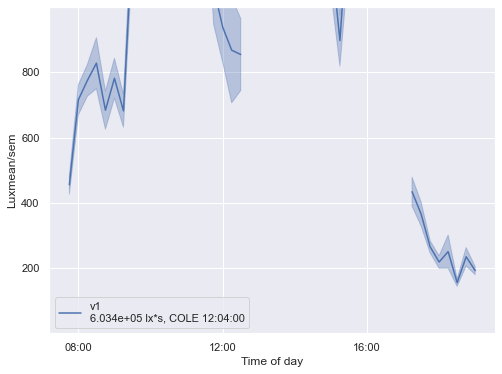

In [ ]:
sns.set(style="darkgrid")
plot_light([v1["White Light"]], ["v1"])

v1 - cumulative Lux*sec: 1.361034e+05, center of mass of light exposure: 11:44:00


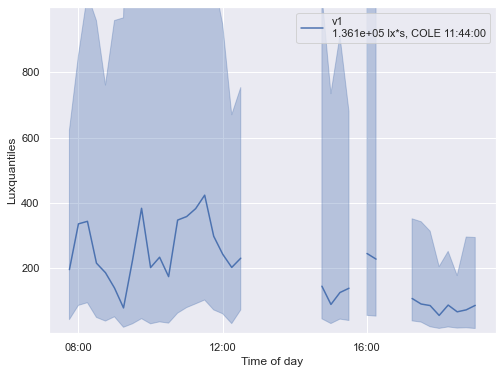

In [ ]:
plot_light([v1["White Light"]], ["v1"], toplot = "quantiles")

In [ ]:
#plot_light([v1["White Light"]], ["v1"], toplot = "counts")

NameError: name 'd1m' is not defined

## Missing Variables:

### Function Line # 22: 

Can be found in the original SALA package cell in line # 32.

    1. d1m
    2. d2m
  